# Spin-charge separation for fermions

In this notebook we take a look at the separation of spin and charge dynamics for fermionic atoms in a 1D system. It is based on the paper by "Time-Resolved Observation of Spin-Charge Deconfinement in Fermionic Hubbard
Chains" the Munich group [[1]](#References).  In these experiments, fermions evolve in a one dimensional optical lattice. The experiment allows for site resolved observation of spin and charge, such that the famous spin charge separation is directly observable. It is therefore a very pedagogical example for microscopic observables in an extended system.

Here, the physical dynamics of the 1-D tweezer array are governed by a Fermi-Hubbard Hamiltonian in second quantization: 

$$ 
 H_{\text{FH}}(\boldsymbol{J},U,\boldsymbol{\mu}) =  -J \underbrace{\sum_{i=1,\sigma}^{L-1} (f^\dagger_{i,\sigma} f_{i+1,\sigma} + f^\dagger_{i+1,\sigma} f_{i,\sigma} )}_{\text{Tunneling/Hopping}} + \underbrace{U \sum_{i=1}^{L}  n_{i,\uparrow}n_{i,\downarrow}}_{\text{interaction}} + \underbrace{\sum_{i=1,\sigma}^{L} \mu_i n_{i,\sigma}}_{\text{potential offset}} 
$$

Here, $f_{i,\sigma}, f^\dagger_{i,\sigma}$ are annihilation/creation operators for atoms in tweezers at site $i$ with spin $\sigma$ and $n_{i,\sigma} = f^\dagger_{i,\sigma} f_{i,\sigma}$ is the number operator.  

The dynamics depend on the parameters $\{ \boldsymbol{J}, U, \boldsymbol{\mu} \}$ that determine the strength of the different contributions:

- The first term describes hopping between the site $i$ and its neighboring site $i+1$ (for both spin species) through the tunnel effect. The parameter $J$ determines the strength of this hopping and can be tuned by adjusting the depth of the optical lattice.
    
- The second term describes an interaction between two atoms when they occupy the same site. It is controlled globally by the parameter $U$ set by an external magnetic field exploiting a Feshbach resonance.

- The third term describes local offsets in the potential which can locally imprint a phase by tuning $\mu_i$. Throughout this tutorial we will set $\mu_i = 0$ for all sites $i$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Initial state preparation

As described in the paper, the initial state is a system of alternating spin-up and spin-down fermions in the lattice. To initialize the system only the site in the middle is left empty.

In [2]:
from qiskit_cold_atom.fermions import FermionSimulator, FfsimBackend

from qiskit_cold_atom.fermions.fermion_gate_library import FermiHubbard
from qiskit_nature.operators.second_quantization import FermionicOp
from qiskit.circuit import Parameter

# backend = FermionSimulator()
backend = FfsimBackend()

We will attempt to obverve propagations of up to `d` sites. Let us initialize a system with `2d+1` sites. And in the middle of the lattice we will leave one site empty.

In [3]:
def prep_init_states(dmax: int, with_hole: bool) -> tuple[list, list]:
    """
    Prepares a list of initial states for the Fermi-Hubbard model.

    Args:
        dmax: the maximum distance from the center
        with_hole: whether to include a hole in the initial state

    Returns:
        two lists of initial states starting with spin-up and spin-down, respectively
    """
    Nsites = 2 * dmax + 1

    # the up state
    state_up = [i % 2 for i in range(Nsites)]
    state_down = [(i + 1) % 2 for i in range(Nsites)]

    if with_hole:
        state_up[dmax] = 0
        state_down[dmax] = 0

    init_state_1 = [state_up, state_down]
    init_state_2 = [state_down, state_up]

    return init_state_1, init_state_2

In [4]:
dmax = 3
Nsites = 2 * dmax + 1

init_state_1, init_state_2 = prep_init_states(dmax, with_hole=True)

In [5]:
hop_param = Parameter("hop_param")
int_param = Parameter("int_param")
# initialize one spin-up and one spin-down atom in the left tweezer
qc_1 = backend.initialize_circuit(init_state_1)

# apply a global Fermi-Hubbard gate with interaction
qc_1.fhubbard(j=hop_param * np.ones(Nsites - 1), u=int_param, mu=np.zeros(Nsites), modes=range(2*Nsites))
qc_1.measure_all()

# qc_1.draw(output="mpl")

However, this is not the only configuration that exists. Actually the total spin is on average zero. The only thing that is known is that we start out with an anti-ferromagnetic configuration.

In [6]:
hop_param_down = Parameter("hop_param")
int_param_down = Parameter("int_param")

# initialize one spin-up and one spin-down atom in the left tweezer
qc_2 = backend.initialize_circuit(init_state_2)

# apply a global Fermi-Hubbard gate with interaction
qc_2.fhubbard(
    j=hop_param_down * np.ones(Nsites - 1),
    u=int_param_down,
    mu=np.zeros(Nsites),
    modes=range(2 * Nsites),
)
qc_2.measure_all()

In [7]:
circuit_up_init = qc_1.bind_parameters({hop_param: 0, int_param: 0})
job_up_init = backend.run(circuit_up_init, shots=5, num_species=2)

circuit_down_init = qc_2.bind_parameters({hop_param_down: 0, int_param_down: 0})
job_down_init = backend.run(circuit_down_init, shots=5, num_species=2)

In [8]:
print("measured counts in the up config: ", job_up_init.result().get_counts())
print("measured counts in the up config: ", job_up_init.result().get_memory())

print("measured counts in the down config: ", job_down_init.result().get_counts())
print("measured counts in the down config: ", job_down_init.result().get_memory())

measured counts in the up config:  {'01000101010101': 5}
measured counts in the up config:  ['01000101010101', '01000101010101', '01000101010101', '01000101010101', '01000101010101']
measured counts in the down config:  {'10101010100010': 5}
measured counts in the down config:  ['10101010100010', '10101010100010', '10101010100010', '10101010100010', '10101010100010']


Now let us plot up the density and charge density of the different states.

In [9]:
def nocc_from_counts(counts: dict[str, int], Nsites: int) -> np.ndarray:
    """
    The calculates the occupation from all observed configurations.

    Args:
        counts: the counts of the observed configurations
        Nsites: the number of sites in the system

    Returns:
        1D array The occupation for each site
    """
    nocc_t = np.zeros(Nsites)
    Nobs = 0
    for occ_string, observations in counts.items():
        # get the occupation of each site in the observed configuration
        nocc = np.zeros(Nsites)

        for site_index in range(Nsites):
            nocc[site_index] = int(occ_string[site_index]) + int(occ_string[site_index + Nsites])

        # now add the value to the correct time step and with it by the number of observations
        Nobs = Nobs + observations
        nocc_t = nocc_t + nocc * observations
    return nocc_t / Nobs


def squeezed_spin_corr_from_counts(counts: dict[str, int], Nsites: int) -> np.ndarray:
    """
    The calculates the spin projection from all observed configurations.
    However, we filter out situations with a hole and a doublon in the system.

    Args:
        counts: the counts of the observed configurations
        Nsites: the number of sites in the system

    Returns:
        1D array The occupation for each site
    """
    sz_squeeze = np.zeros(Nsites)
    szvar = np.zeros(Nsites)
    Nobs = 0
    Nobs_var = np.zeros(Nsites)
    Nobs = np.zeros(Nsites)

    for occ_string, observations in counts.items():
        occ_int = [int(occ) for occ in occ_string]
        # get the spin of each site in the observed configuration
        sz = np.zeros(Nsites)
        nocc = np.zeros(Nsites)
        for site_index in range(Nsites):
            sz[site_index] = 1 / 2 * (occ_int[site_index] - occ_int[site_index + Nsites])
            nocc[site_index] = occ_int[site_index] + occ_int[site_index + Nsites]

        # now obtain the symmetrized variance
        # first for the first site
        site_index = 0
        if nocc[site_index] == 1 and nocc[site_index + 1] == 1:
                    szvar[site_index] = (
                        szvar[site_index] + sz[site_index] * sz[site_index + 1] * observations
                    )
                    Nobs_var[site_index] = Nobs_var[site_index] + observations
        
        # then for the last site
        site_index = Nsites - 1
        if nocc[site_index] == 1 and nocc[site_index - 1] == 1:
                    szvar[site_index] = (
                        szvar[site_index] + sz[site_index] * sz[site_index - 1] * observations
                    )
                    Nobs_var[site_index] = Nobs_var[site_index] + observations
        
        # and finally for all the other sites
        for site_index in range(1,Nsites-1):
            if (
                    nocc[site_index] == 1
                    and nocc[site_index + 1] == 1
                    and nocc[site_index - 1] == 1
                ):
                    szvar[site_index] = (
                        szvar[site_index]
                        + 1
                        / 2
                        * sz[site_index]
                        * (sz[site_index + 1] + sz[site_index - 1])
                        * observations
                    )
                    Nobs_var[site_index] = Nobs_var[site_index] + observations
            elif (
                    nocc[site_index] == 1
                    and nocc[site_index + 1] == 1
                    and nocc[site_index - 1] == 0
                ):
                    szvar[site_index] = (
                        szvar[site_index] + sz[site_index] * sz[site_index + 1] * observations
                    )
                    Nobs_var[site_index] = Nobs_var[site_index] + observations
            elif (
                    nocc[site_index] == 1
                    and nocc[site_index + 1] == 0
                    and nocc[site_index - 1] == 1
                ):
                    szvar[site_index] = (
                        szvar[site_index] + sz[site_index] * sz[site_index - 1] * observations
                    )
                    Nobs_var[site_index] = Nobs_var[site_index] + observations

        sz_squeeze += sz * (nocc == 1) * observations
        Nobs += (nocc == 1) * observations

    # regularize the observations
    var_weight = 1 / Nobs_var
    var_weight[np.isinf(var_weight)] = 0

    mean_weight = 1 / Nobs
    mean_weight[np.isinf(mean_weight)] = 0
    # now that we have gone through all observations, we can average
    fluc = np.zeros(Nsites)
    for site_index in range(Nsites):
        if site_index == 0:
            fluc[site_index] = 4 * (
                szvar[site_index] * var_weight[site_index]
                - sz_squeeze[site_index]
                * mean_weight[site_index]
                * sz_squeeze[site_index + 1]
                * mean_weight[site_index + 1]
            )
        elif site_index == Nsites - 1:
            fluc[site_index] = 4 * (
                szvar[site_index] * var_weight[site_index]
                - sz_squeeze[site_index]
                * mean_weight[site_index]
                * sz_squeeze[site_index - 1]
                * mean_weight[site_index - 1]
            )
        else:
            fluc[site_index] = 4 * (
                szvar[site_index] * var_weight[site_index]
                - sz_squeeze[site_index]
                * mean_weight[site_index]
                * (
                    sz_squeeze[site_index + 1] * mean_weight[site_index + 1]
                    + sz_squeeze[site_index - 1] * mean_weight[site_index - 1]
                )
                / 2
            )
    return fluc, Nobs_var, Nobs

Let us just visualize the initial state:

In [19]:
noccs_init = np.zeros( Nsites)
corrs_init = np.zeros(Nsites)

counts_1 = job_up_init.result().get_counts()
counts_2 = job_down_init.result().get_counts()
total_counts = counts_1
total_counts.update(counts_2)

nocc = nocc_from_counts(total_counts, Nsites)
corr, _, _ = squeezed_spin_corr_from_counts(total_counts, Nsites)

/var/folders/_v/vw5sh5fd4lv4x0cnk8cxz__w0000gn/T/ipykernel_66007/44761851.py:114: RuntimeWarning: divide by zero encountered in divide
  var_weight = 1 / Nobs_var
/var/folders/_v/vw5sh5fd4lv4x0cnk8cxz__w0000gn/T/ipykernel_66007/44761851.py:117: RuntimeWarning: divide by zero encountered in divide
  mean_weight = 1 / Nobs


Text(0.5, 0, 'site index')

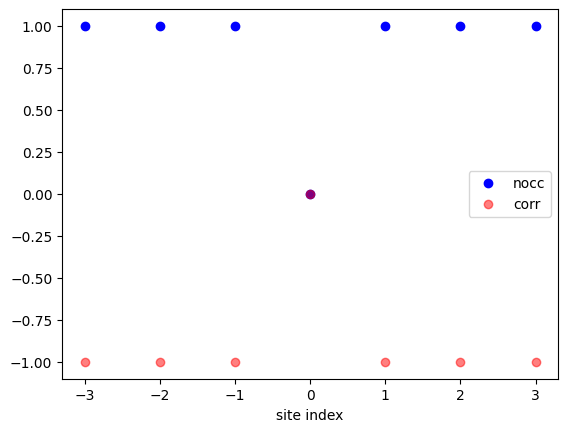

In [21]:
f, ax = plt.subplots()

ax.plot(np.arange(Nsites) - dmax, nocc, "bo", label="nocc")
ax.plot(np.arange(Nsites) - dmax, corr, "ro", label="corr", alpha = 0.5)
ax.legend()
ax.set_xlabel("site index")

As we can see, we have created a state with alternating spins. However, in the middle we have created a hole. This is the state that we will use as the initial state for the propagation.

## Time evolution

To directly simulate the experiment, we run a list of circuits with different evolution times on the simulator backend. 

In [12]:
# the experimental parameters
J = 2 * np.pi * 250  # hopping parameter in units of hbar
U = 15 * J  # interaction parameter

Ntimes = 8
tmax = 1.5
times = np.linspace(0, tmax, Ntimes) * 1e-3

In [13]:
Nshots = 500
# create list of circuits with interaction
circuits_1 = [qc_1.bind_parameters({hop_param: J * t, int_param: U * t}) for t in times]
# measure the observable from simulated shots
jobs_1 = backend.run(circuits_1, shots=Nshots, num_species=2)

# create list of circuits with interaction
circuits_2 = [qc_2.bind_parameters({hop_param_down: J * t, int_param_down: U * t}) for t in times]
# measure the observable from simulated shots
jobs_2 = backend.run(circuits_2, shots=Nshots, num_species=2)

Put it together

In [14]:
noccs = np.zeros((Ntimes, Nsites))
corrs = np.zeros((Ntimes, Nsites))

count_list_1 = jobs_1.result().get_counts()
count_list_2 = jobs_2.result().get_counts()
for ii in range(Ntimes):
    counts_1 = count_list_1[ii]
    counts_2 = count_list_2[ii]

    total_counts = counts_1
    total_counts.update(counts_2)

    nocc = nocc_from_counts(total_counts, Nsites)
    corr, _,_ = squeezed_spin_corr_from_counts(total_counts, Nsites)

    noccs[ii, :] = nocc
    corrs[ii, :] = corr

ic| 'Starting the loop'
/var/folders/_v/vw5sh5fd4lv4x0cnk8cxz__w0000gn/T/ipykernel_66007/44761851.py:114: RuntimeWarning: divide by zero encountered in divide
  var_weight = 1 / Nobs_var
/var/folders/_v/vw5sh5fd4lv4x0cnk8cxz__w0000gn/T/ipykernel_66007/44761851.py:117: RuntimeWarning: divide by zero encountered in divide
  mean_weight = 1 / Nobs


And we can directly visualize them.

Text(0.5, 1.0, 'Density')

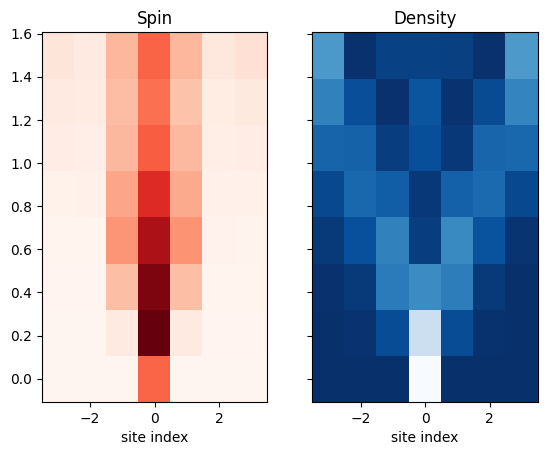

In [15]:
f, [ax1, ax2] = plt.subplots(1, 2, sharey=True)
# color plot of the occupation in a heatmap
velo = J
ax1.pcolor(np.arange(Nsites) - dmax, times * 1e3, corrs, cmap="Reds")

ax1.set_xlabel("time [ms]")
ax1.set_xlabel("site index")
ax1.set_title("Spin")

ax2.pcolor(np.arange(Nsites) - dmax, times * 1e3, noccs, cmap="Blues")
ax2.set_xlabel("site index")
ax2.set_title("Density")

We can nicely observe a much slower spread in the spin than in the charge density. This is the spin-charge separation. Now it is time to quantify the difference in the speed of the spread

In [16]:
stds_spin = np.zeros(Ntimes)
for ii, corr in enumerate(corrs):
    mass_func = corr + 1
    mean_position = np.average(np.arange(len(mass_func)), weights=mass_func)
    # Calculate the standard deviation of the position
    std_position = np.sqrt(
        np.average((np.arange(len(mass_func)) - mean_position) ** 2, weights=mass_func)
    )
    stds_spin[ii] = std_position

stds_density = np.zeros(Ntimes)
for ii, nocc in enumerate(noccs):
    # print(nocc)
    mass_func = 1 - nocc
    mean_position = np.average(np.arange(len(mass_func)), weights=mass_func)
    # Calculate the standard deviation of the position
    std_position = np.sqrt(
        np.average((np.arange(len(mass_func)) - mean_position) ** 2, weights=mass_func)
    )
    stds_density[ii] = std_position

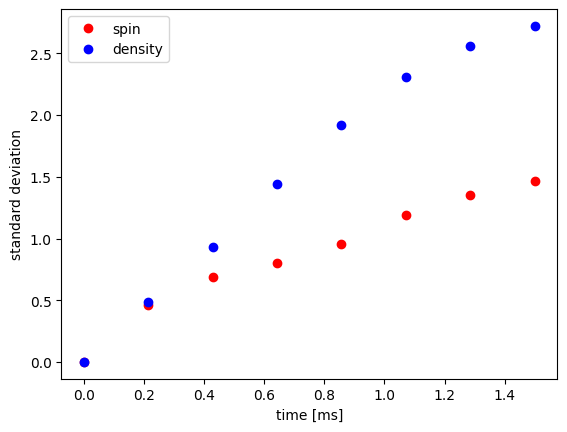

In [17]:
f, ax = plt.subplots()
ax.plot(times * 1e3, stds_spin, "ro", label="spin")
ax.plot(times * 1e3, stds_density, "bo", label="density")
ax.set_xlabel("time [ms]")
ax.set_ylabel("standard deviation")
ax.legend()

This is exactly the expected behavior for the decoupling of spin and density. The density spreads much faster than the spin. This is the spin-charge separation.

# Conclusion

In this notebook we have seen how to simulate the dynamics of a fermionic system in a 1D lattice. We have seen how to initialize the system in an anti-ferromagnetic configuration and how to measure the spin and density dynamics. We have seen how the spin and density dynamics decouple and how this can be quantified.

## References

[1] [Jayadev Vijayan et al.](https://arxiv.org/abs/1905.13638) *Time-Resolved Observation of Spin-Charge Deconfinement in Fermionic Hubbard Chains*. Science 367, 186 (2020).

In [ ]:
import qiskit.tools.jupyter

%qiskit_version_table